In [2]:
import pandas as pd 
import math
import matplotlib.pyplot as pyplot 
from matplotlib.pyplot import draw 
from sklearn.model_selection  import KFold
import numpy as np
import numpy.core.defchararray as np_f
from scipy import stats


def sub(a,b):
    arr =np.zeros(len(a))
    for i in range(len(a)):
        arr[i] = a[i]-b[i]
    return arr


def sum(a,b):
    arr =np.zeros(len(a))
    for i in range(len(a)):
        arr[i] = a[i]+b[i]
    return arr    

def normalize(x):
    data_norm = x - x.mean(axis=0)
    data_norm = data_norm / x.max(axis=0)
    ones = np.ones((data_norm.shape[0],1))
    data_norm = np.hstack((ones,data_norm))
    return data_norm


def costCV(x,y,theta):
    m = x.shape[0]
    one= np.ones(x.shape)
    first_term = sub(np.dot(x,theta),y)
    second_term = sub(np.dot(x, theta) , y)
    J = (1/(2*m) )* np.sum(np.power(first_term,2) )
    return J

def cost(x,y,theta,lamba,alpha,degree):
    m = x.shape[0]
    one= np.ones(x.shape)
    first_term = sub(np.dot(x,theta),y)
    second_term = sub(np.dot(x, theta) , y)
    J = (1/(2*m) )* np.sum(np.power(first_term,2) ) +  ( (lamba/(2*m))*  np.sum(np.dot(theta,theta))  )
    return J


def gradientDescentMulti(X, y, theta, lamba ,alpha, num_iters,degree):   
    m = X.shape[0]  
    theta = theta.copy() 
    J_history = []    
    for i in range(num_iters):    
        h=np.dot(X,theta)     
        theta= theta*(1-((alpha*lamba)/m)) - (    (alpha/m)  *        ( np.dot(sub(h,y) , X )    )     )
        J_history.append(cost(X, y, theta,lamba,alpha,degree))
    
    return theta, J_history


grad_descent_iterations =50
k_fold_num =3
first_degree =3     #second hypo degree
sec_degree=9        #third hypo degree
df = pd.read_csv("house_prices_data_training_data.csv",header = 0)
df = df.dropna()           #drop nan values

ite_grpah_copy = None       #for graph purpose
error_grpah_copy = None    #for graph purpose

In [3]:
for iteration_no in range(0, k_fold_num):
       # load csv file into a dataFrame
    df_sampled=df.sample(frac=1).reset_index(drop=True)
    arr = df_sampled.drop(['price','id','date','zipcode','lat','long' ] , axis=1).values # convert dataFrame into a numpy matrix / array
    length = len(arr)
    prices = df[['price']].values
    
    training_data=normalize( arr[0:math.ceil(length*0.6)] )
    cv_data = normalize(arr[math.ceil(length*0.6):math.ceil(length*0.8)])
    test_data = normalize( arr[math.ceil(length*0.8): len(arr)] )
    
    train_prices=prices[0:math.ceil(length*0.6)]
    cv_prices=prices[math.ceil(length*0.6):math.ceil(length*0.8)]
    test_prices = ( prices[math.ceil(length*0.8): len(arr)] )
    
    

    x3_train_data=np.power(training_data[:,0:first_degree+1], np.array(range(0,first_degree+1)))
    x9_train_data=np.power(training_data[:,0:sec_degree+1], np.array(range(0,sec_degree+1)))

    x3_cv_data=np.power(cv_data[:,0:first_degree+1], np.array(range(0,first_degree+1)))
    x9_cv_data=np.power(cv_data[:,0:sec_degree+1], np.array(range(0,sec_degree+1)))

    x3_test_data=np.power(test_data[:,0:first_degree+1], np.array(range(0,first_degree+1)))
    x9_test_data=np.power(test_data[:,0:sec_degree+1], np.array(range(0,sec_degree+1)))


    #---------------------------------First hypothesis----------------------------------------------------------------------

    ''' the following code is implemented on my first hypothesis which is linear and has 16 features 
        h(x)= theta0*x0 + theta1*x1 +  theta2*x2 ......... + theta15*x15  '''

    print ('k-fold no',iteration_no,' for linear hypo')
    lambdas=np.array([0,0.16,0.64,1.32])

    thetas,J_history=( gradientDescentMulti( training_data,train_prices,np.zeros(training_data.shape[1]),0,0.01,grad_descent_iterations,2  ) )         
    thetas2,J_history2=( gradientDescentMulti( training_data,train_prices,np.zeros(training_data.shape[1]),0.16,0.01,grad_descent_iterations,2  ) )
    thetas3,J_history3=( gradientDescentMulti( training_data,train_prices,np.zeros(training_data.shape[1]),0.64,0.01,grad_descent_iterations,4  ) )
    thetas4,J_history4=( gradientDescentMulti( training_data,train_prices,np.zeros(training_data.shape[1]),1.32,0.01,grad_descent_iterations,10  ) )
    
    best_thetas=np.array([thetas,thetas2,thetas3,thetas4])

    cv_cost1_func1 =costCV(cv_data,cv_prices,thetas)
    cv_cost2_func1 =costCV(cv_data,cv_prices,thetas2)
    cv_cost3_func1 =costCV(cv_data,cv_prices,thetas3)
    cv_cost4_func1 =costCV(cv_data,cv_prices,thetas4)

    cv_errors= np.array([cv_cost1_func1,cv_cost2_func1,cv_cost3_func1,cv_cost4_func1])
    best_lambda = lambdas[ np.argmin(cv_errors, axis=0) ]
    best_theta_for_testing= best_thetas[ np.argmax(cv_errors, axis=0) ]

    print('test_cost_function : ',cost(test_data,test_prices,best_theta_for_testing,best_lambda,0,0))
    print('test_best lambda :',best_lambda)
    print('cost of cv when lmbda =0 :',cv_cost1_func1)
    print('cost of cv when lmbda =0.16 :',cv_cost2_func1)
    print('cost of cv when lmbda =0.64 :',cv_cost3_func1)
    print('cost of cv when lmbda =1.32 :',cv_cost4_func1)
    print('__________________________________________________________________________________________________________')


    #----------------------------------------------Hypothesis 2-----------------------------------------------------------------------------

    ''' the following code is implemented on my second hypothesis which is a polynomial of degree = 3 and has 4 features 
        h(x)= theta0*x0 + theta1*x1^1 +  theta2*x2^2  +  theta3*x3^3  '''

    print ('k-fold no',iteration_no,' for deg=3 hypo')
    lambdas=np.array([0,0.16,0.64,1.32])

    thetas,J_history=( gradientDescentMulti( x3_train_data,train_prices,np.zeros(x3_train_data.shape[1]),0,0.01,grad_descent_iterations,2  ) )         
    thetas2,J_history2=( gradientDescentMulti( x3_train_data,train_prices,np.zeros(x3_train_data.shape[1]),0.16,0.01,grad_descent_iterations,2  ) )
    thetas3,J_history3=( gradientDescentMulti( x3_train_data,train_prices,np.zeros(x3_train_data.shape[1]),0.64,0.01,grad_descent_iterations,4  ) )
    thetas4,J_history4=( gradientDescentMulti( x3_train_data,train_prices,np.zeros(x3_train_data.shape[1]),1.32,0.01,grad_descent_iterations,10  ) )

    best_thetas=np.array([thetas,thetas2,thetas3,thetas4])

    cv_cost1_func1 =costCV(x3_cv_data,cv_prices,thetas)
    cv_cost2_func1 =costCV(x3_cv_data,cv_prices,thetas2)
    cv_cost3_func1 =costCV(x3_cv_data,cv_prices,thetas3)
    cv_cost4_func1 =costCV(x3_cv_data,cv_prices,thetas4)

    cv_errors= np.array([cv_cost1_func1,cv_cost2_func1,cv_cost3_func1,cv_cost4_func1])
    best_lambda = lambdas[ np.argmin(cv_errors, axis=0) ]
    best_theta_for_testing= best_thetas[ np.argmax(cv_errors, axis=0) ]

    print('test_cost_function :',cost(x3_test_data,test_prices,best_theta_for_testing,best_lambda,0,0))
    print('test_best_lambda :' ,best_lambda)
    print('cost of cv when lmbda =0:',cv_cost1_func1)
    print('cost of cv when lmbda =0.16 :',cv_cost2_func1)
    print('cost of cv when lmbda =0.64 : ',cv_cost3_func1)
    print('cost of cv when lmbda =1.32 : ',cv_cost4_func1)
    print('__________________________________________________________________________________________________________')


    #--------------------------------------------- hypothesis 3------------------------------------------------------------------------------


    ''' the following code is implemented on my second hypothesis which is a polynomial of degree = 9 and has 10 features 
        h(x)= theta0*x0 + theta1*x1^1 +  theta2*x2^2  + theta3*x3^3 ..... + theta9*x9^9  '''

    print ('k-fold no',iteration_no,' for deg=9 hypo')
    lambdas=np.array([0,0.16,0.64,1.32])

    thetas,J_history=( gradientDescentMulti( x9_train_data,train_prices,np.zeros(x9_train_data.shape[1]),0,0.01,grad_descent_iterations,2  ) )         
    thetas2,J_history2=( gradientDescentMulti( x9_train_data,train_prices,np.zeros(x9_train_data.shape[1]),0.16,0.01,grad_descent_iterations,2  ) )
    thetas3,J_history3=( gradientDescentMulti( x9_train_data,train_prices,np.zeros(x9_train_data.shape[1]),0.64,0.01,grad_descent_iterations,4  ) )
    thetas4,J_history4=( gradientDescentMulti( x9_train_data,train_prices,np.zeros(x9_train_data.shape[1]),1.32,0.01,grad_descent_iterations,10  ) )
    
    
    ite_grpah_copy= np.arange(len(J_history))
    error_grpah_copy= J_history.copy()

    best_thetas=np.array([thetas,thetas2,thetas3,thetas4])

    cv_cost1_func1 =costCV(x9_cv_data,cv_prices,thetas)
    cv_cost2_func1 =costCV(x9_cv_data,cv_prices,thetas2)
    cv_cost3_func1 =costCV(x9_cv_data,cv_prices,thetas3)
    cv_cost4_func1 =costCV(x9_cv_data,cv_prices,thetas4)

    cv_errors= np.array([cv_cost1_func1,cv_cost2_func1,cv_cost3_func1,cv_cost4_func1])
    best_lambda = lambdas[ np.argmin(cv_errors, axis=0) ]
    best_theta_for_testing= best_thetas[ np.argmax(cv_errors, axis=0) ]
    
    print('train_cost :',cost(x9_test_data,test_prices,best_theta_for_testing,best_lambda,0,0))
    print('best lambda :',best_lambda)
    print('cost of cv when lmbda =0 :',cv_cost1_func1)
    print('cost of cv when lmbda =0.16 :',cv_cost2_func1)
    print('cost of cv when lmbda =0.64 :',cv_cost3_func1)
    print('cost of cv when lmbda =1.32 :',cv_cost4_func1)
    print('__________________________________________________________________________________________________________')
    

(10800, 16)
(3600, 16)
(3599, 16)
(10800, 1)
(3600, 1)
(3599, 1)
k-fold no 0  for linear hypo
test_cost_function :  156743693925.18127
test_best lambda : 0.0
cost of cv when lmbda =0 : 158728297057.8242
cost of cv when lmbda =0.16 : 158728355258.29617
cost of cv when lmbda =0.64 : 158728529859.2019
cost of cv when lmbda =1.32 : 158728777209.1755
__________________________________________________________________________________________________________
k-fold no 0  for deg=3 hypo
test_cost_function : 156738372929.29
test_best_lambda : 0.0
cost of cv when lmbda =0: 158724476575.4957
cost of cv when lmbda =0.16 : 158724534780.11798
cost of cv when lmbda =0.64 :  158724709393.47458
cost of cv when lmbda =1.32 :  158724956761.08688
__________________________________________________________________________________________________________
k-fold no 0  for deg=9 hypo
train_cost : 156729383769.61697
best lambda : 0.0
cost of cv when lmbda =0 : 158717766555.653
cost of cv when lmbda =0.16 : 15871

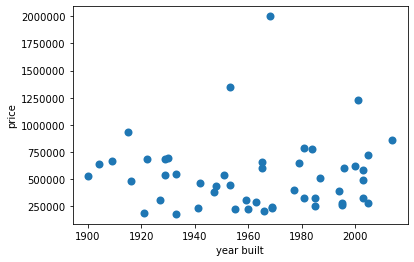

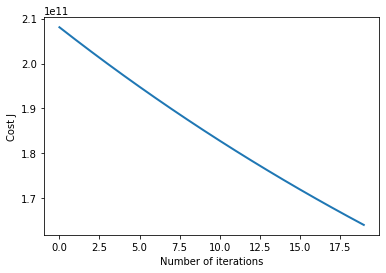

In [4]:
pyplot.figure()
pyplot.scatter( df[['yr_built']][0:50].values,  df[['price']][0:50].values, lw=2)
pyplot.xlabel('year built')
pyplot.ylabel('price')

pyplot.figure()
pyplot.plot(ite_grpah_copy, error_grpah_copy, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')
pyplot.show()